# Titanic

In [1]:
from pandas import DataFrame, Series
import numpy as np
from collections import Counter
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

<br>
### Target submission format

In [2]:
gender_submission = DataFrame.from_csv('res/gender_submission.csv')
gender_submission[:3]

,Survived
PassengerId,
892,0
893,1
894,0


<br>
### Loding training data and testing data

In [3]:
train = DataFrame.from_csv("res/train.csv")
test = DataFrame.from_csv("res/test.csv")
train[:3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<br>
* PassengerId => 乘客ID
* Pclass => 乘客等級(1/2/3等艙位)
* Name => 乘客姓名
* Sex => 性別
* Age => 年齡
* SibSp => 堂兄弟/妹個數
* Parch => 父母與小孩個數
* Ticket => 船票信息
* Fare => 票價
* Cabin => 客艙
* Embarked => 登船港口

<br>
## Feature preprocessing

In [4]:
def preprocessing(df, select_feature, replace_value=Series([])):
    df = df.loc[:, select_feature]
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
    if len(replace_value) == 0:
        mean_v = train[['Age', 'Fare', 'SibSp', 'Parch']].mean()
        mode_v = train[['Pclass', 'Sex']].mean()
        replace_value = mean_v.append(mode_v)
    
    df = df.fillna(replace_value)
    return df, replace_value


<br>
### Exploration

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

explore_feature = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
df, replace_value = preprocessing(train.copy(), explore_feature)

<br>
Age versus survival

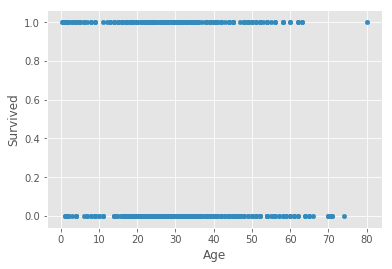

In [6]:
df.plot(kind='scatter', x='Age', y='Survived')

<br>
Fare versus survival

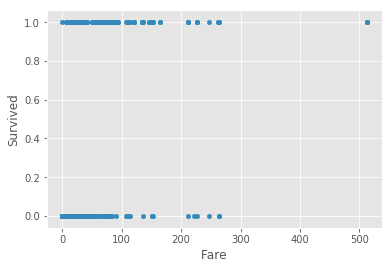

In [7]:
df.plot(kind='scatter', x='Fare', y='Survived')

In [8]:
Select_Feature = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
training_df, replace_value = preprocessing(train.copy(), Select_Feature)
testing_df, _ = preprocessing(test.copy(), Select_Feature, replace_value)
# df[df.isnull().any(axis=1)] # check if any null number

training_df[:3]

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,0,22.0,1,0,7.2500
2,1,1,38.0,1,0,71.2833
3,3,1,26.0,0,0,7.9250


<br>
### Tree

In [9]:
from pandas import DataFrame, Series
import numpy as np
from datetime import datetime, timedelta
from collections import Counter

from sklearn import tree
import graphviz 

training_data = training_df.as_matrix()
testing_data = testing_df.as_matrix()

label = train['Survived']
class_name = ['not survived', 'survived']

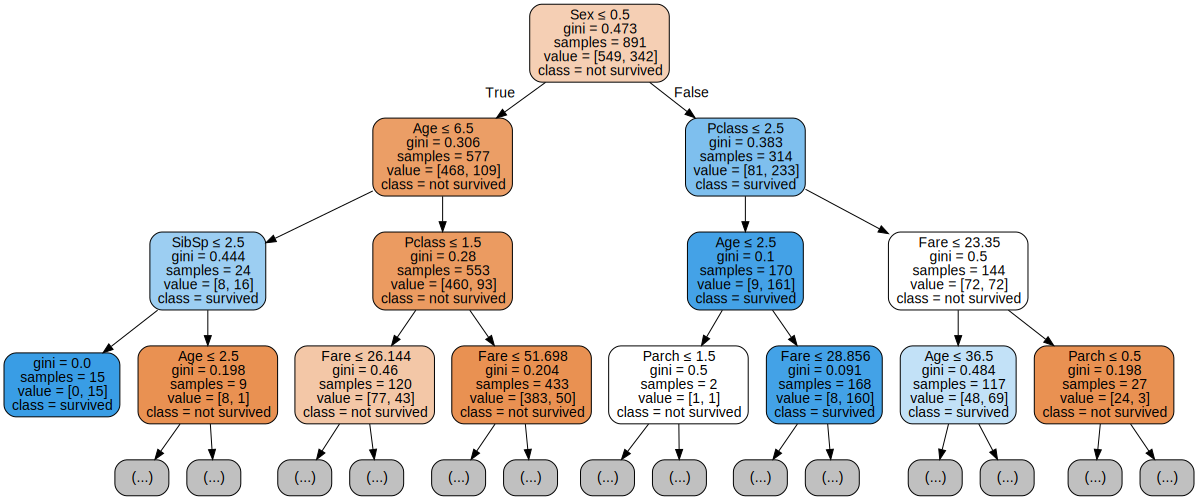

In [11]:
#clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = tree.DecisionTreeClassifier()
clf = clf.fit(training_data, label)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("rule") 

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=training_df.columns,  
                         class_names=class_name,  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         max_depth=3)  
graph = graphviz.Source(dot_data)  
graph

In [12]:
test_result = clf.predict(testing_data)
result = DataFrame(test_result, index=test.index, columns=['Survived'])
result.to_csv('result.csv')
result[:3]

,Survived
PassengerId,
892,0
893,0
894,1
